---
# Reviewer comments

In [1]:
from linescanning import (
    utils,
    prf,
    plotting,
    optimal
)
import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
import os
from pRFline.utils import SubjectsDict
from pRFline import figures
import seaborn as sns
opj = os.path.join

# Set defaults

In [2]:
# set defaults
task        = "task-pRF"
base_dir    = "/data1/projects/MicroFunc/Jurjen/projects/VE-pRF"
prog_dir    = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline"
# design_dir  = opj(prog_dir, "data_lp3")
design_dir  = opj(base_dir, "derivatives", "prf")
fig_dir     = opj(prog_dir, "figures")
data_dir    = opj(prog_dir, "data")
results_dir = opj(prog_dir, "results")

In [3]:
# fetch subject dictionary from pRFline.utils.SubjectsDict
model = "gauss"
subj_obj = SubjectsDict()
dict_data = subj_obj.dict_data
process_subjs = subj_obj.get_subjects()
process_subjs

['sub-001', 'sub-002', 'sub-003', 'sub-005', 'sub-007', 'sub-008']

In [4]:
colors=["#DE3163", "#6495ED"]
cmap1 = utils.make_binary_cm(colors[0])

subjects = list(dict_data.keys())
cmap_subj = "Set2"
sub_colors = sns.color_palette(cmap_subj, len(subjects))
subjects

['sub-001', 'sub-002', 'sub-003', 'sub-005', 'sub-007', 'sub-008']

# R1.1 - curvature in line

For this answer, we can use the patch containing the vertex in the beam that was projected to the slice. 

In [125]:
params_fn = opj(data_dir, f"sub-all_model-{model}_desc-full_params.csv")
im3e = figures.CurvatureInLine(
    full_dict=params_fn, 
    verbose=True)

Reading '/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/data/sub-all_model-gauss_desc-full_params.csv'
Reading '/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/data/sub-all_desc-curvature_ribbon.csv'
Reading '/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/data/sub-all_desc-contamination.csv'


In [126]:
im3e.df_cont.head()

,run,percentage,tissue,code,subject
0,1,67.857143,gm,0,sub-001
1,1,32.142857,wm,1,sub-001
2,1,0.000000,csf,2,sub-001
0,1,56.250000,gm,0,sub-002
1,1,43.750000,wm,1,sub-002


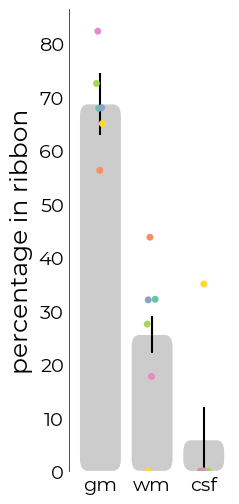

In [179]:
bar_plot = plotting.LazyBar(
    data=im3e.df_cont,
    x="tissue",
    y="percentage",
    figsize=(2,6),
    add_labels=True,
    y_label2="percentage in ribbon",
    sns_ori="v",
    fancy=True,
    fancy_denom=6,
    hue=None,
    points_hue="subject",
    points_cmap=im3e.sub_colors,   
    color="#cccccc",
    add_points=True,
    # points_color="k",
    # points_alpha=0.4,
    sns_offset=4
)

In [142]:
im3e.df_cont.groupby(["run","tissue"]).mean()

percentage  code
run tissue                  
1   csf       5.833333   2.0
    gm       68.644593   0.0
    wm       25.522073   1.0

In [140]:
bar_plot.sem

array([5.83333333, 3.5075757 , 6.15035073])

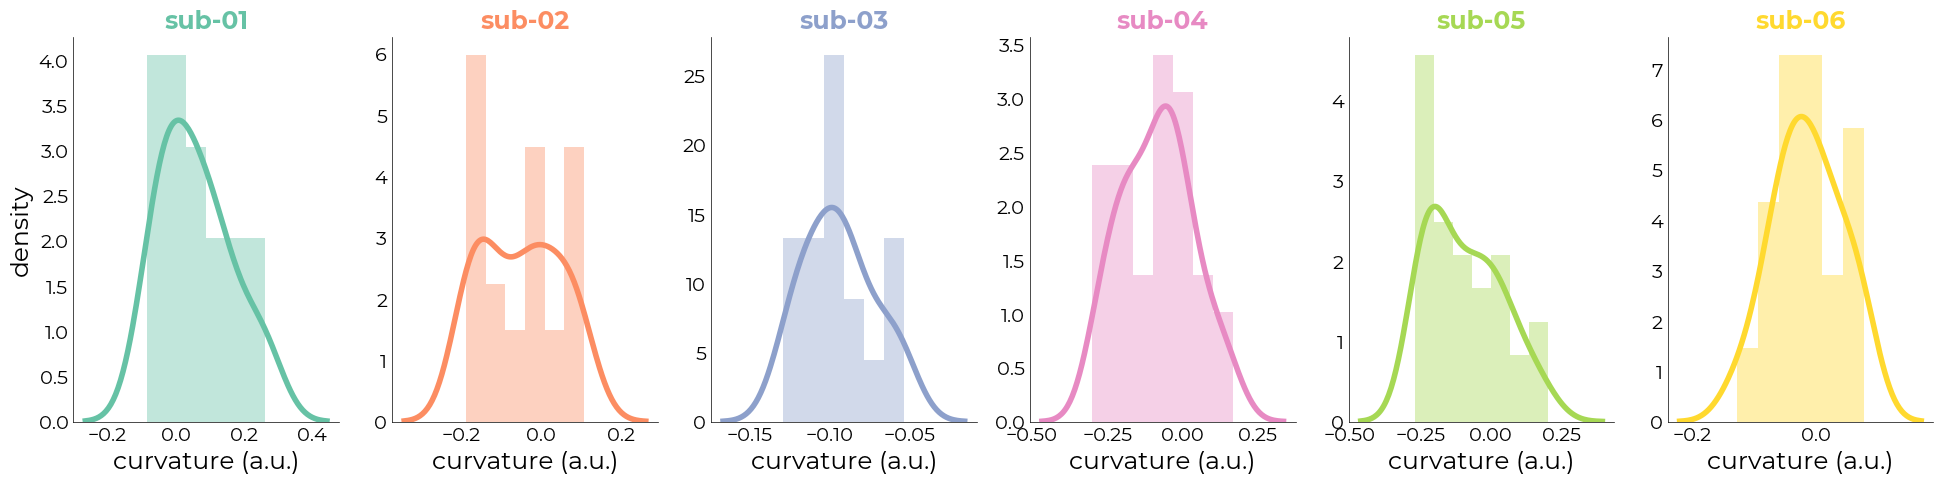

In [175]:
im3e.plot_curvature_distributions()

In [76]:
image = "/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/sub-001/ses-2/func/sub-001_ses-2_task-pRF_run-1_desc-ribbon.nii.gz"
crs = "/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/nighres/sub-001/ses-2/sub-001_ses-1_acq-1slice_run-1_desc-cruise_cortex.nii.gz"

rib_voxels = np.rot90(nb.load(image).get_fdata().squeeze())
seg = np.rot90(nb.load(crs).get_fdata().squeeze())
rib_voxels.shape

(720, 720)

In [85]:
# get nr of unique voxels in line direction
bbox = np.where(rib_voxels>0)
vox_x = np.unique(bbox[1])
n_vox = vox_x.shape[0]

mx = np.ma.masked_greater(rib_voxels,0)
rib_seg = seg[rib_voxels.astype(bool)].reshape(16,n_vox)

total = rib_seg.size
wm = np.count_nonzero(rib_seg==2)
csf = np.count_nonzero(rib_seg==0)

tpm_wm = (wm/total)*100
tpm_csf = (csf/total)*100

32.142857142857146

In [72]:
bbox = np.where(rib_voxels>0)
vox_x = np.unique(bbox[0])
vox_x.shape[0]

7

In [34]:
len(im3e.curv_plot.kde_)

2

In [6]:
# find the beam file
ribbon_file = opj(
    base_dir,
    "derivatives",
    "freesurfer",
    subjects[-1],
    "mri",
    f"{subjects[-1]}_ses-2_{task}_space-fsnative_hemi-LR_run-1_desc-ribbon.npy"
)

if os.path.exists(ribbon_file):
    beam_data = np.load(ribbon_file)
else:
    raise FileNotFoundError(f"Could not find beam in surface space ('{ribbon_file}')")
beam_data.shape

(469117,)

In [7]:
# get the surface information for the curvature
surfs = optimal.SurfaceCalc(subject=subjects[-1], fs_dir=opj(base_dir, "derivatives", "freesurfer"))

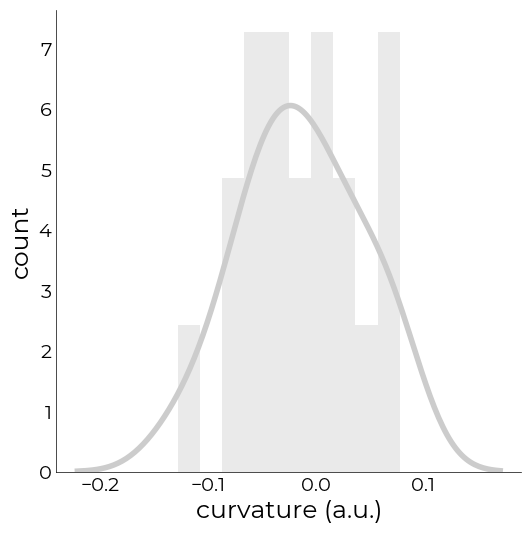

In [15]:
%matplotlib inline
curvs = surfs.curvature.data[beam_data>0]
reg_plot = plotting.LazyHist(
    curvs,
    figsize=(6,6),
    kde=True,
    hist=True,
    fill=False,
    y_label2="count",
    x_label2="curvature (a.u.)",
    # color=self.sub_colors[sub_ix],
    hist_kwargs={"alpha": 0.4},
    kde_kwargs={"linewidth": 4},
    bins=10
)